# Running Dynamical Models on ALMA data cubes to estimate black hole (BH) masses.

#### by Kyle M. Kabasares

In this notebook, we will go over the basics of fitting dynamical models to ALMA data cubes for the purpose of measuring supermassive black hole (BH) masses at the centers of galaxies. We will go over the importance of this endeavor, as well as explain the necessary inputs required to performing a dynamical measurement of a BH mass.

# A Very Brief History of the Importance of BH Mass Measurements

The launching of the *Hubble Space Telescope* in 1990 and its subsequent repair operations in 1993 ushered in a new era of astronomy. With a 2.4 meter telescope in low-Earth orbit, astronomers no longer had to compete with Earth's atmosphere, which can cause blurring effects within astronomical images due to its turbulent nature. Within 2 years of Hubble's repair, researchers had started trying to measure BH masses by using long-slit spectrographs on Hubble to observe ionized gas in rotation around the very centers of these galaxies. These studies of ionized gas dynamics in the mid to late 1990s were the precursors to the molecular gas dynamical studies we perform today with ALMA. 

In 2000, two groups discovered a correlation between measured BH mass, $M_{\mathrm{BH}}$, and stellar velocity dispersion, $\sigma_{\star}$, of stars within the bulge component of a galaxy. This empirical correlation, which was derived from the handful of BH mass measurements up until that point, has since become known as the $M-\sigma$ relation. Hundreds, if not thousands, of papers have since been written to understand this connection between the BH mass and its host galaxy. In essence, this correlation tells us that if we measure the stellar velocity dispersion of the bulge component of a galaxy, such as using long-slit spectrographs to look at the stellar absorption and nebular emission lines and observing their redshifts, we can use $M-\sigma$ to get an estimate of the BH mass. In addition, more correlations connecting the BH mass to bulge luminosity, $L_{\mathrm{Bulge}}$ and bulge mass $M_{\mathrm{Bulge}}$, have since been identified. 

What makes these correlations so strange? Well, for starters, although these BHs are supermassive, they often only make up less than 0.1% of the galaxy's bulge mass. Why does the BH, which affects objects on such a small scale in comparison to the entire galaxy, seem to be strongly linked to galaxy parameters that are measured over much larger scales? It would be as if a single grain of sand in your room somehow has a direct, quantifiable influence on you and your room's composition.

Thus, the idea of **feedback** was born. This is the idea that the BH and host galaxy directly influence each other. The galaxy provides the BH gas and stars to feed on and grow, and the BH disrupts the growth of the galaxy at its very center, and thus, correlations between the BH and the host galaxy arise. This is a very simple picture that has a lot of profound questions such as: When did these correlations begin? How do they stop? What are the physical mechanisms that occur? Are galaxy types linked to the kinds of BHs they have at their center?. 

In addition to these questions, a number of **problems** have arisen in the time BH mass meausurements have started. For instance, there have been primarily 2 methods of BH mass measurements over the years: stellar dynamics and ionized gas dynamics, and multiple measurements of the same BH using these methods have led to differing results, usually by a factor of 2-4 for the BH mass. No doubt, this conflict between the 2 methods have led to questions regarding the reliability of each method. Each suffer from their share of problems, but the Atacama Large Millimeter/submillimeter Array (ALMA) has the potential to circumvent nearly all of them, which is why ALMA observations of galaxies with rotating molecular gas are so important.

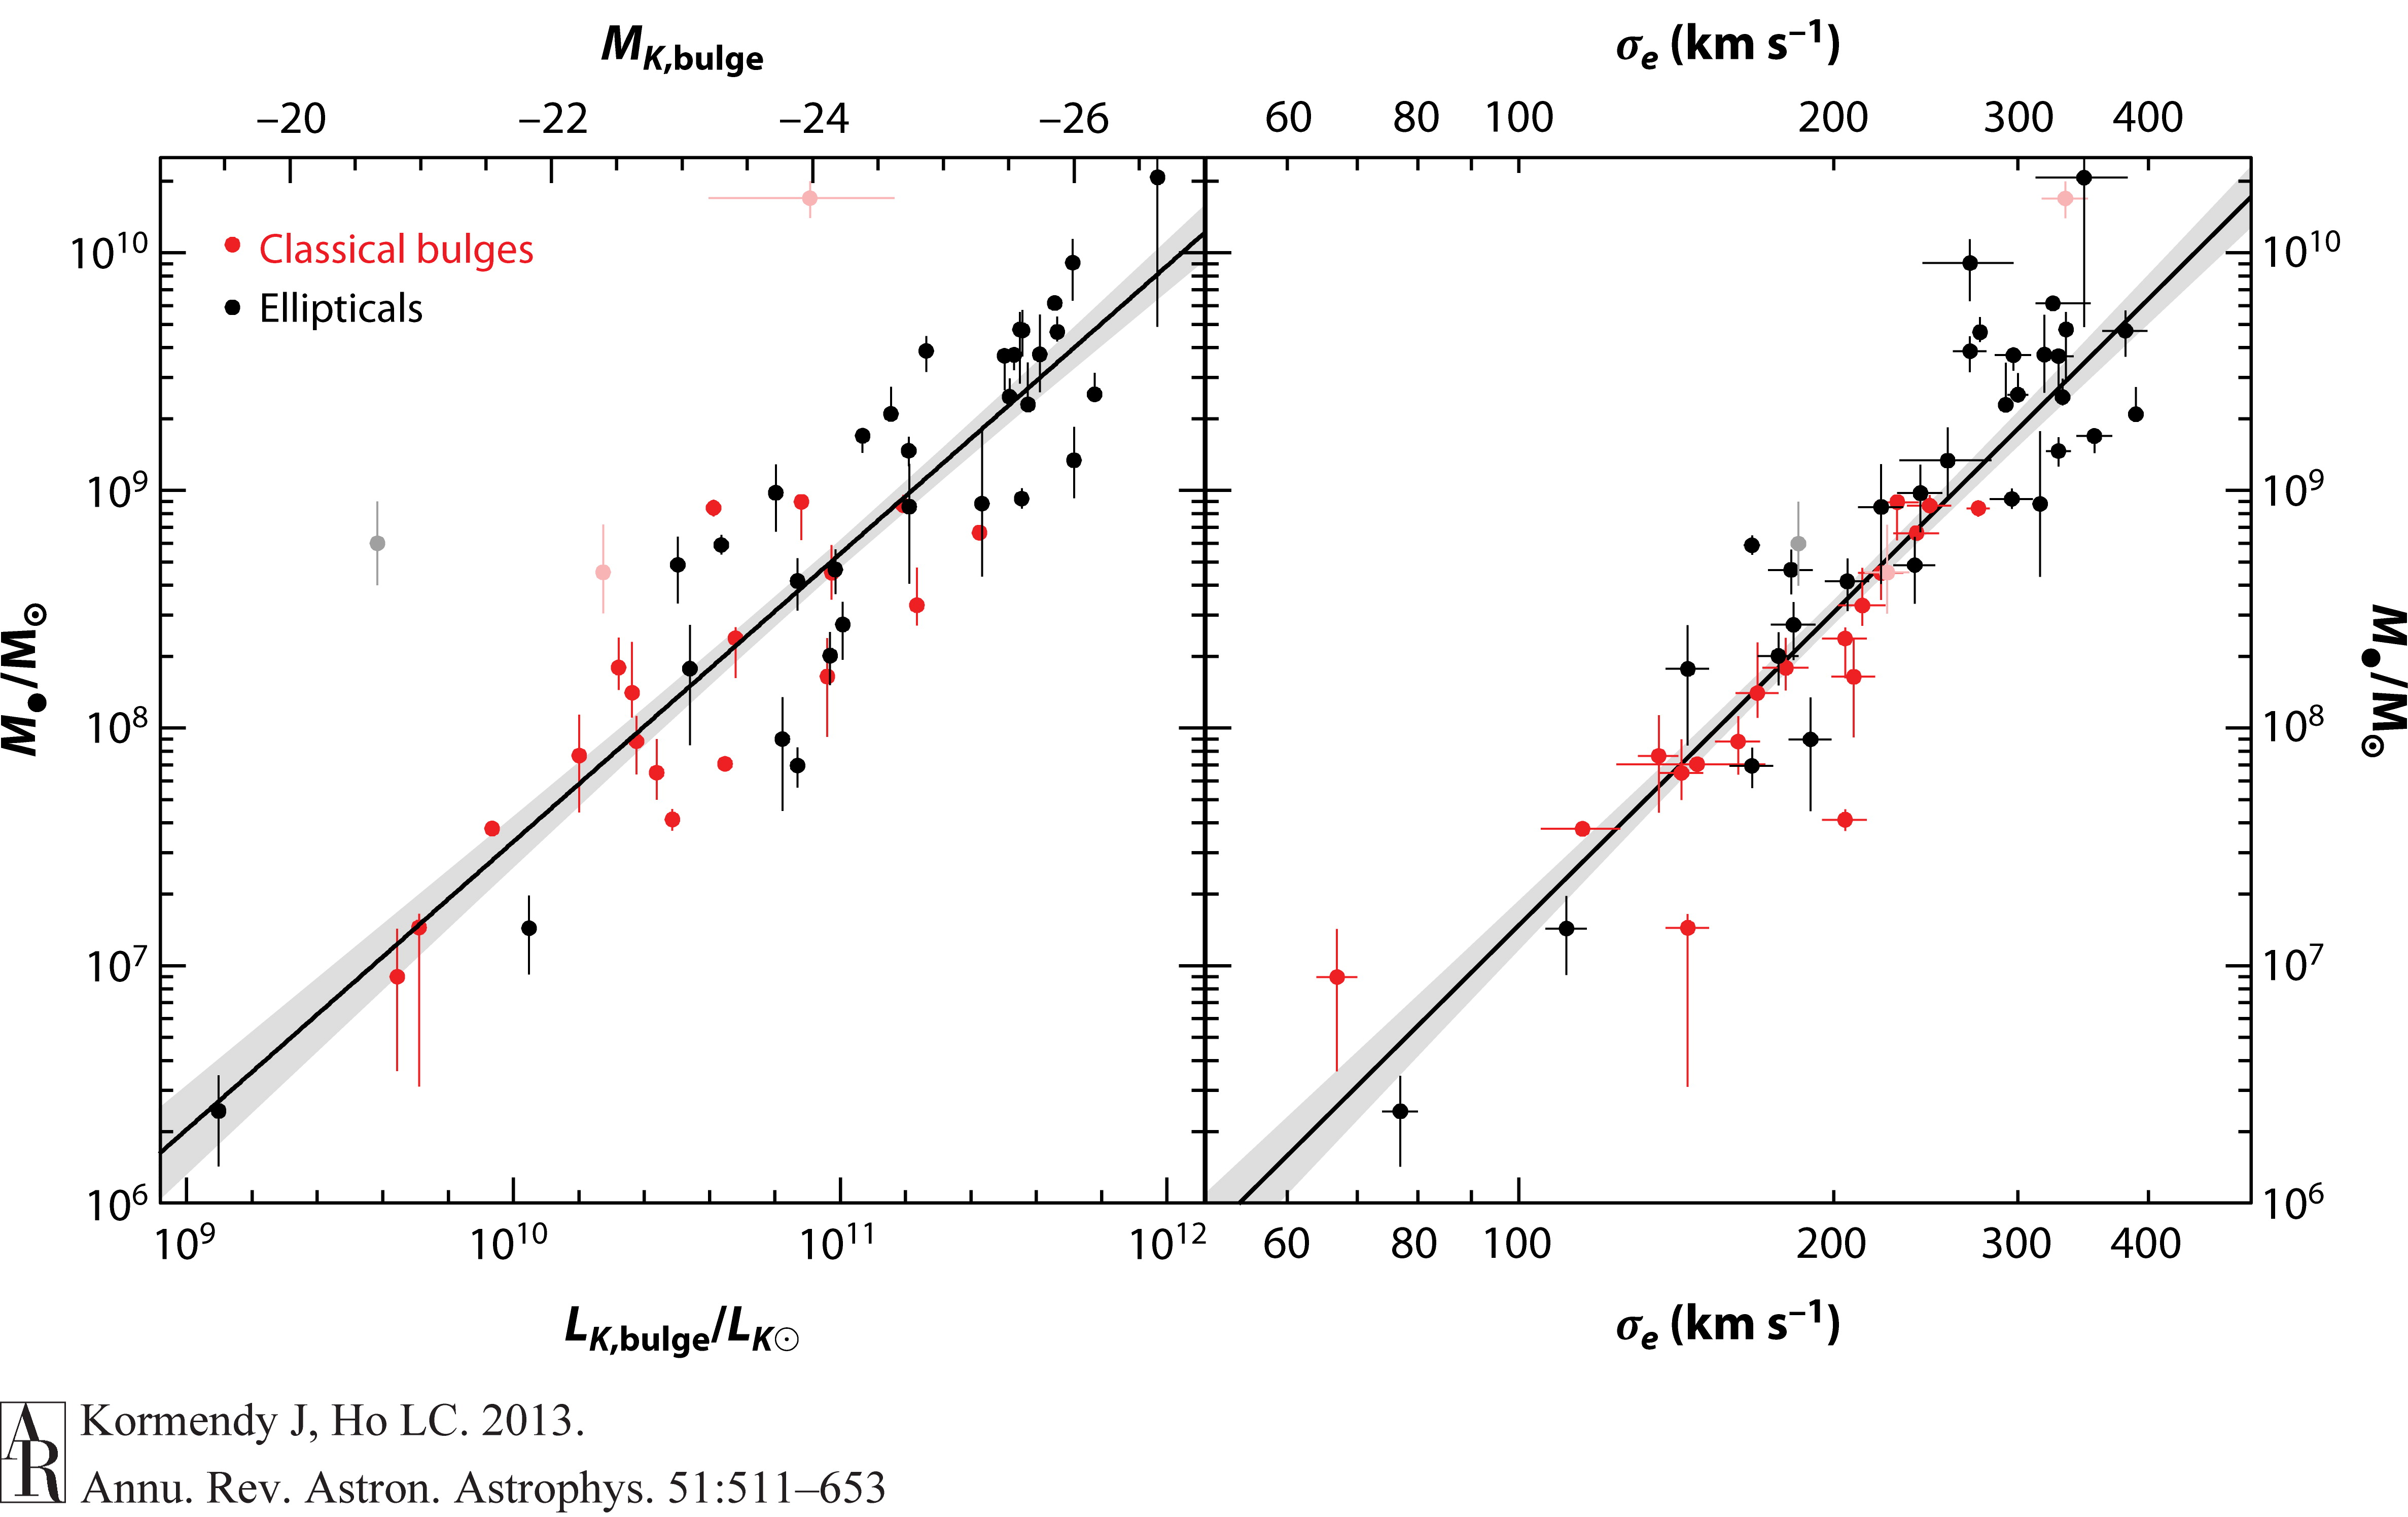

An image from Kormendy and Ho (2013) showing the $M-\sigma$ and $M-L$ relationships.

## $$ M(r) = c_1 r^{\beta} $$

# Packages Needed to Run the Dynamical Modeling Code

If you cannot run the following cell, try "pip install package" to get any missing packages installed into your environment.

In [1]:
import numpy as np
import numpy.ma as ma
from numpy import *
import astropy
import math
import scipy 
from scipy import interpolate
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
from IPython.display import clear_output
from scipy.interpolate import griddata
from scipy.signal import convolve2d as conv2
from scipy.ndimage import rotate
from skimage import color, data, restoration
import pafit
import jampy
from jampy import mge_vcirc
from pafit import fit_kinematic_pa
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.plot_velfield import plot_velfield
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import (MinMaxInterval, AsinhStretch,ImageNormalize)
from astropy.convolution import Gaussian2DKernel
from astropy.modeling.functional_models import Gaussian2D
from scipy.signal import convolve as scipy_convolve
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import lmfit 
from lmfit import Model, Minimizer, Parameters, report_fit
from astropy.modeling.models import Ellipse2D
from astropy.modeling.models import Box2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import Angle
from astropy.nddata.utils import block_reduce 
import matplotlib.patches as mpatches
from astropy import wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# Additional User-Defined Functions 

In [2]:
def swap_cube_axes(data_cube):
    """ 
    Purpose
    -------

    Interchange the axes of an ALMA data cube so it is properly oriented in Python.
    
    Input parameters
    ----------------
    
    data_cube: A 3D ALMA data cube imported into Python.
    
     Written by Kyle K. M. Kabasares 
     """
    
    newdata_cube = np.swapaxes(np.swapaxes(data_cube,0,2),0,1)
    
    return newdata_cube

In [3]:
def upsample(A,ssf):
    """ 
    Purpose
    -------

    Take an input flux map and scale it up by the subsampling factor, ssf, that has been determined for the given
    dynamical modeling process.
    
    Input parameters
    ----------------
    
    A: The input flux map that has the same spatial scale as the original ALMA data cube's spatial axes.
    
    ssf: The factor the spatial dimensions will be scaled by. For example, if the input flux map has the dimensions
    (dx,dy), then the output flux map will have the dimensions (ssf*dx,ssf*dy)
              
     Written by Kyle M. Kabasares
    """
    
    B = np.repeat(A,ssf,axis=0)
    C = np.repeat(B,ssf,axis=1)
    C = C/(ssf**2)
    
    return C

In [4]:
def freq_axis(data_cube):
    """ 
    Purpose
    -------
    Create the frequency axis of an input ALMA data cube.
    
    Input parameters
    ----------------
    
    data_cube: The string of the ALMA data cube file. i.e. if the data cube file is "cube.fits", type
    "freq_axis('cube.fits')"
              
     Written by Kyle M. Kabasares
     
    """
    
    
    # Open and extract the data from the input data cube 
    hdu = fits.open(data_cube)
    hdu.info()
    data = hdu[0].data
    
    # Speed of light in km/s
    c = 299792.458
    # Pick out the 3 dimensions of the data cube and swap axes to have the axes ordered 
    # as x,y,z
    data = data[0,:,:,:]
  

    # At this point, the order of the axes is: (z,x,y). 
    # We have to interchange z with y to get (y,x,z), and then switch x and y to get it in regular (x,y,z) -> (RA,dec,freq)
    data = swap_cube_axes(data)
    
    # Dimensions of each axis in the data cube 
    dx = int(np.size(data,0))
    dy = int(np.size(data,1))
    dz = int(np.size(data,2))
    
    restfreq = hdu[0].header['RESTFRQ']/1e9
    f_init = hdu[0].header['CRVAL3']
    f_spacing = hdu[0].header['CDELT3'] # frequency step in the data cube

    f_range = np.zeros(dz)
    for i in range(dz):
        f_range[0] = f_init
        f_range[i] = f_range[i-1] + f_spacing
    
    f_range = f_range/1e9 #Convert into GHz

    return f_range

In [5]:
def noisecube(pbcordata,filename,paramfile,primbeam=None):
    
    """ 
    Purpose
    -------
    This program will create two noise cubes, 1 that takes into account the primary beam correction and 1 that
    doesn't, using an ALMA primary-beam corrected data cube and the primary beam itself. 
    
    Input parameters
    ----------------
    
    pbcordata: String of the file name of the original ALMA data cube that the noise will be calculated from.
    If the cube's name is 'cube.fits', then type that string (with quotes) into the first argument.
    
    paramfile: .txt parameter file that contains the information regarding the spatial regions the noise will 
    be calculated on and determines its output size. The required parameters that need to be listed are as follows:
        
            xlo_data: Leftmost x position of the spatial fit region in the data cube 
                      as determined by the user.
            
            xhi_data: Rightmost x position of the spatial fit region in the data cube 
                      as determined by the user.
                      
            ylo_data: Bottommost y position of the spatial fit region in the data cube 
                      as determined by the user.
            
            
            yhi_data: Topmost y position of the spatial fit region in the data cube 
                      as determined by the user.
                      
            xlo_noise: Leftmost x position of the noise region in the data cube 
                       as determined by the user.
            
            xhi_noise: Rightmost x position of the noise region in the data cube 
                       as determined by the user.
                       
            ylo_noise: Bottommost y position of the noise region in the data cube 
                       as determined by the user.
                       
            yhi_noise: Topmost y position of the noise region in the data cube 
                       as determined by the user.
                       
            rebin: Rebinning factor that you want to downsample the data to.
            
    OPTIONAL INPUTS:
            prim_beam: String of the primary beam data cube 

            
    Written by Kyle K. M. Kabasares
    """
    
    # Import the ALMA data and correctly orient it.
    hdul = fits.open(pbcordata)
    data = hdul[0].data
    data = data[0,:,:,:]
    data = swap_cube_axes(data)
    
    # Create the non-primary-beam corrected data cube by multiplying each slice of the .pbcor cube
    # with each slice of the primary beam cube
    
    dx = np.size(data,1)
    dy = np.size(data,0)
    dz = np.size(data,2)
    flatcube = np.zeros((data.shape))
    
    # Identify the square region that the dynamical models will be built on and the region the noise will be 
    # extracted on
    
    FILE = open(paramfile,"r")
    fixedparameters = defaultdict(str)
    for line in FILE:
        paramval = line.strip().split('=')
        fixedparameters[paramval[0].strip()] = paramval[1].strip()

    xlo_data = int(fixedparameters['xlo_data'])
    xhi_data = int(fixedparameters['xhi_data'])
    ylo_data = int(fixedparameters['ylo_data'])
    yhi_data = int(fixedparameters['yhi_data'])
    
    xlo_noise = int(fixedparameters['xlo_noise'])
    xhi_noise = int(fixedparameters['xhi_noise'])
    ylo_noise = int(fixedparameters['ylo_noise']) 
    yhi_noise = int(fixedparameters['yhi_noise']) 
    
    rebin = int(fixedparameters['rebin'])  
    # Identify the spatial region the data is extracted on by creating a spatial array 
    # Make the map 0 everywhere except in the region where the data is taken 
    # This will be rebinned to produce a noise cube on the same scale as the final ALMA data model in the dynamical
    # program 
    
    # Rebin the data_map array by a factor of rebin
    # Noise region 
    noise_map = np.zeros((dy,dx))
    noise_map[ylo_noise:yhi_noise,xlo_noise:xhi_noise] = 1
    
    # Rebin this noise map by the factor of the rebin scale
    noise_maprebin = block_reduce(noise_map,rebin,np.mean)
    
    # This identifies the location of where we want to extract the noise on the rebinned scale
    noise_mapindicator = np.where(noise_maprebin == 1)
    noise_x = noise_mapindicator[1]
    noise_y = noise_mapindicator[0]
    
    # for loop that will iterate the process of creating 
    
    data_rebin = np.zeros((int(dx/rebin),int(dy/rebin),dz))
    noise_vector_pbcor = np.zeros(dz)
    
    # Create the noise cubes using a for loop by multiplying the measurement of the standard deviation of the 
    # noise on both the flat cube scale and the .pbcor scale by the ones arrays I've generated.
    
    # Pre-allocate the final noise cube arrays
    data_subset = data[ylo_data:yhi_data,xlo_data:xhi_data,:]
    
    # Create a ones cube that will be used to store the noise information per slice on the rebinned scale 
    subdx = np.size(data_subset,1)
    subdy = np.size(data_subset,0)
    
    # This noise cube is on the scale of the final rebinned model cube
    uniformnoise = np.ones((int(subdy/rebin),int(subdx/rebin),dz))
    
    for k in range(dz):
        
        # Rebin the primary beam corrected data cube, primary beam itself, and the non-corrected primary beam cube
        data_rebin[:,:,k] = block_reduce(data[:,:,k],rebin,np.mean)
   
        # Take a noise measurement from the flat (non primary beam corrected) data cube
        noise_vector_pbcor[k] = np.std(data_rebin[noise_y,noise_x,k])
        
        # Store the flat noise and the varying noise in cubes of the correct shape
        uniformnoise[:,:,k] = noise_vector_pbcor[k]*uniformnoise[:,:,k]
    
    # Save the cubes in a .fits file
    hdul_staticnoise = fits.PrimaryHDU(np.swapaxes(uniformnoise,0,2))
    filename1 = filename + '.fits'
    hdul_staticnoise.writeto(filename1,overwrite=True)
    
    return uniformnoise
    
    if primbeam is not None:
        
    # Import the primary beam cube and correctly orient it.
        hdul2 = fits.open(primbeam)
        pbeam = hdul2[0].data
        pbeam = pbeam[0,:,:,:]
        pbeam = swap_cube_axes(pbeam)

        
        pbeam_rebin = np.zeros((int(dx/rebin),int(dy/rebin),dz))
        flatcube_rebin = np.zeros((int(dx/rebin),int(dy/rebin),dz))
        noise_vector_flat = np.zeros(dz)
        uniformnoise = np.ones((int(subdy/rebin),int(subdx/rebin),dz)) 
    
    # Create the flat-cube from the .pbcor data cube and the primary beam data cube.
        for k in range(dz):
            flatcube[:,:,k] = data[:,:,k]*pbbeam[:,:,k]
        
    # This noise cube is on the scale of the final rebinned model cube
        varyingnoise = np.ones((int(subdy/rebin),int(subdx/rebin),dz))
    
        for k in range(dz):
        # Rebin the primary beam corrected data cube, primary beam itself, and the non-corrected primary beam cube
            data_rebin[:,:,k] = block_reduce(data,rebin,np.mean)
            pbeam_rebin[:,:,k] = block_reduce(pbeam,rebin,np.mean)
            flatcube_rebin[:,:,k] = block_reduce(flatcube,rebin,np.mean)
        
        # Take a noise measurement from the flat (non primary beam corrected) data cube
            noise_vector_uniform[k] = np.std(flatcube_rebin[noise_mapindicator,k])
            noise_vector_pbcor[k] = np.std(data_rebin[noise_mapindicator,k])
        
        # Store the flat noise and the varying noise in cubes of the correct shape
            uniformnoise[:,:,k] = noise_vector_flat[k]*uniformnoise[:,:,k]
            varyingnoise[:,:,k] = noise_vector_pbcor[k]/pbeam_rebin[:,:,k]
        
        
    # Save the cubes in a .fits file
    hdul_staticnoise = fits.PrimaryHDU(swap_cube_axes(uniformnoise))
    filename1 = filename + '.fits'
    hdul_staticnoise.writeto(filename1,overwrite=True)
    
    hdul_varyingnoise = fits.PrimaryHDU(swap_cube_axes(varyingnoise))
    filename2 = filename + '.fits'
    hdul_varyingnoise.writeto(filename2,overwrite=True)
    
    return uniformnoise,varyingnoise

# Import the Dynamical Modeling Program

In [57]:
def dynamical(freeparams,textparamfile,galaxyname,f_range,FluxMap,datacube,eps,method=None,r_int=None,vc_st=None,r_gas_int=None,vc_gas=None,modelcube=None,fit_region=None,SaveFITS=False):

    """ 
    Purpose
    -------

    This program creates model integrated Gaussian line profiles and optimizes them to ALMA data cubes for the 
    purpose of measuring the masses of supermassicve black holes. The optimization makes use of the open-source
    LMFIT package: https://lmfit.github.io/lmfit-py/. 
    
    Input parameters
    ----------------
    
    freeparams: LMFIT parameters that will be used as initial guesses to the model fit and will be optimized with
    each successive iteration.
    
    textparamfile: .txt parameter file that contains the fixed parameter information for the particular galaxy the
    fit will be optimized 
    
         Required parameters
         
         --------------------
        xi: Leftmost x position of the spatial region that will be used in creating a dynamical model. This region
        is typically a subset of the entire spatial region of the original data cube.
        
        xf: Rightmost x position of the spatial region that will be used in creating a dynamical model. This region
        is typically a subset of the entire spatial region of the original data cube.
        
        yi: Bottommost y position of the spatial region that will be used in creating a dynamical model. This region
        is typically a subset of the entire spatial region of the original data cube.
        
        yf: Topmost y position of the spatial region that will be used in creating a dynamical model. This region
        is typically a subset of the entire spatial region of the original data cube.
        
        *** IMPORTANT NOTE *** 
        This region needs to be square, so xf - xi = yf - yi, and the difference between the two regions needs to be
        evenly divisible by the value of the rebin parameter.
        
        nu_i: First frequency channel with visible emission in the data cube.
        
        nu_f: Last frequency channel with visible emission in the data cube.
        
        N: The amount of radial rings used in the v_extended model. 
        
        r_init: The starting radius (in parsecs) where the v_extended model will place its first ring. This number
        is unimportant if the v_extended model is not being used.
        
        G: Netwon's gravitational constant in units where masses are in solar masses, velocities are in km/s, and radii
        are in parsecs. (0.00430237)
        
        dpc: Distance to the galaxy in parsecs.
        
        cs: Speed of light in km/s
        
        sub: Sub-sampling factor. Recommended minimum value is 2.
        
        rebin: The rebinning factor that will set how much the final model is binned down. i.e. If the original
        data cube size is (dx,dy), the rebinned model has a size of (dx/rebin, dy/rebin)
        
        gridsize: Integer (that needs to be odd) that represents how big the primary beam/PSF image will be on
        each side. One good rule of thumb is to make the length larger than 5x the primary beam's average size 
        (take the major and minor axis average) in units of pixels.
        
        a: Semimajor axis of the ellipse that will be used to define the fitting region where the data and model 
        will be compared on.
        
        q: Axial ratio (b/a) of the minor to major axis ratio of the fitting ellipse.
        
        xc_ellipse: x coordinate of the center of the fitting ellipse
        
        yc_ellipse: y coordinate of the center of the fitting ellipse
        
        GammaEllipse: Position angle of the fitting ellipse. This typically needs to be as close to the gas disk
        position angle as possible.
    
    galaxyname: String extension that will be added to all the output files of the program.
    
    f_range: The frequency axis that the model cube will be built on. This is the same frequency axis as the
    original data cube, and can be computed from using the user-defined function "freq_axis".

    FluxMap: A map of integrated flux that will be used to weight the Gaussian line profiles (set the area under
    their curves). This should have the same spatial scale as the original ALMA data cube.
    
    datacube: String of the file name of the original ALMA data cube that models will be built to be compared with.
    
    eps: The noise cube that is used in the chi-squared calculation of the model optimization. The noise cube needs
    to be the same size as the final rebinned model size. 
    
    OPTIONAL INPUTS:
    ----------------
    
    method: Used to choose how we parameterize the stellar mass/stellar circular velocity profile if no
    Multi-Gaussian expansion is available. Currently, the 2 supported options are "vext" and "power" which 
    indicate using either the v_extended model or a simple 2 parameter power law describing the mass profile: 
    M(r) = c1*r^beta
    
    r_int: Radius (in parsecs) of the stellar circular velocity profile. Needs to be the same
    length as "vc_st"
    
    vc_st: Stellar circular velocity (in km/s) profile typically derived from a Multi-Gaussian (MGE) expansion, which is used
    as a proxy for enclosed stellar mass at a given radius. Needs to be the same length as r_int.
    
    r_gas_int: Radius (in parsecs) of the gas disk circular velocity profile. Needs to be the same length as 
    "vc_gas".
    
    vc_gas: Molecular gas disk circular velocity (in km/s) profile. This is typically derived from observations
    of the molecular gas distribution in the ALMA data.
    
    modelcube: An ALMA model cube created from a previous dynamical modeling run. This typically is only used when
    one wants to perform a Monte Carlo simulation to better understand the statistics of the fitting parameters.
    
    fit_region: A 3D array the same dimensions as the final model in the dynamical modeling process that 
    
    SaveFITS: Set to either to True if you wish to save additional .fits files in your working directory (list
    is at the end of the dynamical modeling program), and False if you don't.
    

    Written by Kyle K. M. Kabasares 
     """
    
    clear_output()    
## Clear the previous output
    ### INPUT GRID (FIXED) PARAMETERS FROM TEXT PARAMETER FILE
    FILE = open(textparamfile,"r")
    parameters = defaultdict(str)
    
    for line in FILE:
        paramval = line.strip().split('=')
        parameters[paramval[0].strip()] = paramval[1].strip()
    
  
    xi = int(parameters['xi'])
    xf = int(parameters['xf'])
    yi = int(parameters['yi'])
    yf = int(parameters['yf'])
    z_i = int(parameters['nu_i'])
    z_f = int(parameters['nu_f'])
    N = int(parameters['N'])
    r_init = float(parameters['r_init'])
    G = float(parameters['G']) 
    D = float(parameters['dpc']) 
    cs = float(parameters['cs'])
    ssf = int(parameters['sub'])
    rebin = int(parameters['rebin'])
    gridsize = int(parameters['gridsize'])
    a = float(parameters['a'])
    q = float(parameters['q'])
    xc_ellipse = float(parameters['xc_ellipse'])
    yc_ellipse = float(parameters['yc_ellipse'])
    Gamma = float(parameters['GammaEllipse'])

    # Import the ALMA Data Cube and extract key information from the header
    hdul = fits.open(datacube)
    data = hdul[0].data
    data = data[0,:,:,:]
    data = swap_cube_axes(data)
    print('The shape of the data cube is',data.shape)
    
    # Key information from the header
    # Beam Major and Minor Axis
    x_std = hdul[0].header['BMAJ']*3600
    y_std = hdul[0].header['BMIN']*3600
    print('The major and minor axis of the primary beam in arcseconds is',x_std,y_std)
    
    # Primary Beam Rotation
    resbeamPA = hdul[0].header['BPA']
    PSF_PA = (90.+resbeamPA)*(np.pi/180)
    
    # Pixel Scale 
    res = abs(hdul[0].header['CDELT1']*3600)
    print('The pixel scale is', res)
    
    # Frequency spacing
    f_spacing = hdul[0].header['CDELT3']
    
    # Rest frequency of the molecular gas
    restfreq = hdul[0].header['RESTFRQ']
    print('The rest frequency of the molecular gas line in Hz is',restfreq)

    ### FREE PARAMETERS OF THE MODEL
    mbh = freeparams['mbh']
    MtoL = freeparams['MtoL']
    xc = freeparams['xc']
    yc = freeparams['yc']
    z = freeparams['z']
    theta = freeparams['theta']
    incl = freeparams['incl']
    F_0 = freeparams['F_0']
    sigma_0 = freeparams['sigma_0']
    sigma_1 = freeparams['sigma_1']
    sigma_2 = freeparams['sigma_2']
    mu = freeparams['mu']
    r_0 = freeparams['r_0']
    alpha = freeparams['alpha']
    PSF_scale = freeparams['PSF_scale']
    
    #### PRINT THE CURRENT PARAMETER VALUE 
    print('The black hole mass in solar masses is', float(mbh))
    print('The central x pixel is',float(xc))
    print('The central y pixel is',float(yc))
    print('The position angle is at',float(theta))
    print('The inclination angle is at',float(incl))
    print('The redshift is',float(z))
    print('The Mass to Light ratio is',float(MtoL))
    print('The flux multiplier constant is',float(F_0))
    print('The constant velocity dispersion term is',float(sigma_0))
    print('The amplitude of the velocity dispersion Gaussian is',float(sigma_1))
    print('The amplitude of the velocity dispersion exponential is',float(sigma_2))
    print('The radius offset of the velocity dispersion Gaussian is',float(r_0))
    print('The standard deviation of the velocity dispersion Gaussian is',float(mu))
    print('The value of alpha is',float(alpha))
    print('The value of PSF scale is',float(PSF_scale))
    
    ### Import the FIXED Parameters from the ALMA Parameter File     
    # Start a timer 
    start = time.time()

    # Disk inclination angle and rotation angle (PA)
    # in degrees, where i=0 is face-on and i=90 deg.
    # is edge-on and th=0 is north (up) and th=90 deg. is
    # east (left) of the receding disk major axis.
    # Afterwards, transform these angles to radians and
    # from the inclination angle compute the
    # disk minor/major axis ratio, qv
          
    incl=incl/180.*np.pi
    theta=(270.-theta)/180.*np.pi
    qv=np.cos(incl)
    
    # Construct matrices that define the native x/y positions
    # of an array with (ndx,ndy) dimensions. The native x/y positions
    # are shifted by the (xc,yc) disk centers at this stage.

    if modelcube is None:
        print('No model cube is present')
        
        # Save the original dimensons of the full-sized ALMA grid
        X,Y,Z = data.shape
            
        # Truncate the data to work on a smaller grid 
        data = data[yi:yf,xi:xf,:]
        ndx = np.size(data,1)
        ndy = np.size(data,0)
        ndz = np.size(data,2)
        
        # Pre-Allocate Data Rebin Array
        data_rebin = np.zeros((int(ndy/rebin),int(ndx/rebin),ndz))
        for i in range(ndz):
            data_rebin[:,:,i] = block_reduce(data[:,:,i],rebin,np.mean)
        print('ndx,ndy,and ndz are',(ndx,ndy,ndz))
            
        # Model cube is for fitting to an already made model cube, typically in the context of a Monte Carlo 
        # simulation

    elif modelcube is not None:
        print('Model cube is present')
        
        data = data[yi:yf,xi:xf,:]
        ndx = np.size(data,1)
        ndy = np.size(data,0)
        ndz = np.size(data,2)
        
        # Pre-Allocate Data Rebin Array
        data_rebin = np.zeros((int(ndy/rebin),int(ndx/rebin),ndz))
        for i in range(ndz):
            data_rebin[:,:,i] = block_reduce(data[:,:,i],rebin,np.mean)
        print('ndx,ndy,and ndz are',(ndx,ndy,ndz))
            

    # SAVE THE RE-BINNED DATA FOR FUTURE USE
    print('The filename is',galaxyname)
    figtitle = galaxyname + 'RebinnedData' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(data_rebin,0,2),1,2))
    hdu.writeto(figtitle,overwrite=True)
    
    # Now, we must shift the xc and yc coordinates by the xi,xf, yi, and yf shift.
    xc = xc - xi
    yc = yc - yi
    
    xva=np.linspace(1,ssf*ndx,ssf*ndx)/ssf-xc
    yva=(np.linspace(1,1,ssf*ndy)/ssf)*np.linspace(1,ssf*ndy,ssf*ndy)-yc
    xva, yva = np.meshgrid(xva,yva)    
    
    # Transform the native x/y positions into
    # physical (disk) x/y positions using the
    # disk inclination and rotation angles.
    # Construct array that maps observed pixel
    # to a physical disk radius
    xv=(xva*np.cos(theta)-yva*np.sin(theta))
    yv=(yva*np.cos(theta)+xva*np.sin(theta))/qv
    
    # Radius at a projected location (x',y') on the sky plane
    rv=np.sqrt((xv)**2+(yv)**2)
    
    # Radius map
    plt.figure(1)
    plt.imshow(rv,origin='lower')
    plt.title('Radius (pixels)')
    plt.xlabel('x pixels')
    plt.ylabel('y pixels')
    cb = plt.colorbar()
    cb.set_label('Radius ',fontsize = 16)
    plt.show()
    
    # Compute the fraction of the maximum line-of-sight (LOS)
    # velocity (along the disk major axis) at each observed
    # pixel position
    los_frac=(xva*np.cos(theta)-yva*np.sin(theta))/rv
    
    ## CREATE a los_frac free fall
    los_frac_ff = yv/rv

    # Convert the radius array from pixels to parsecs (pc)
    # Determine the parsec to arcsecond scale
    pc2arcsec = D*np.tan(1/206265)
    
    # Determine the pc to pixel scale
    scale = pc2arcsec*res
    print('The pc to arcsec scale is',pc2arcsec)
    print('The pc to pixel scale is',scale)
    
    rv_pc=rv*scale
    
    ### Stellar and Gas contributions to the circular velocity 
    ### These will be added in quadrature with the black hole mass contribution
    
    if r_int is None and vc_st is None:
        if method is 'vext':
         ### New Free Parameters for the Extended Velocity Distribution with logarithmic bins
        # We start with 10 bins to start
            delta0 = freeparams['delta0']
            delta1 = freeparams['delta1']
            delta2 = freeparams['delta2']
            delta3 = freeparams['delta3']
            delta4 = freeparams['delta4']
            delta5 = freeparams['delta5']
            delta6 = freeparams['delta6']
            delta7 = freeparams['delta7']
            delta8 = freeparams['delta8']
        
            print('The value of delta0 is',float(delta0))
            print('The value of delta1 is',float(delta1))
            print('The value of delta2 is',float(delta2))
            print('The value of delta3 is',float(delta3))
            print('The value of delta4 is',float(delta4))
            print('The value of delta5 is',float(delta5))
            print('The value of delta6 is',float(delta6))
            print('The value of delta7 is',float(delta7))
            print('The value of delta8 is',float(delta8))
    
            ### Create the logarithmic bins for the extended stellar circular velocity profile 
            logxbins = np.logspace(np.log10(r_init),np.log10(a*scale),N)
        
            # Set the first entry to correspond to r = 0.
            logybins = np.zeros((len(logxbins)+1))
            logybins[0] = 0
            logybins[1::] = logxbins[:]
        
            # Create a mass array with N entries, one for each radii
            mguess = np.zeros(N+1)
            mguess[0] = 0
        
            # Create free parameter placeholders
            for i in range(0,N):
                varname = 'm' + str(i)
                mguess[i+1] = freeparams[varname]
            
            print(mguess)
            
        # Accumulate the mass profile in order for it to be monotonically increasing
        # Interpolate the data with a cubic spline on the coarse scale
            interpfunc = interpolate.PchipInterpolator(logybins,mguess)

            # Create a more finely fampled radius vector that we can linearly interpolate over the entire rv_pc grid
            rnew = np.linspace(0,np.rint(a*scale),np.rint(np.round(a*scale)))
        
            # Re-interpolate with the monotonically increasing spline
            newinterpfunc = interpolate.PchipInterpolator(rnew,interpfunc(rnew))
        
            massinterp = np.array(newinterpfunc(rnew))
        
            # Plot the mass as a function of radius with the interpfunc
            plt.plot(rnew,massinterp)
            plt.title('Mass Profile')
            plt.xlabel('r (pc)')
            plt.ylabel('$M_{\odot}$')
            plt.show()
        
            # Convert the enclosed mass into a circular velocity at each radii 
            # Set the circular velocity to be 0 at r = 0
            vcirc = np.zeros(np.size(massinterp))
            vcirc[0] = 0
            vcirc[1::] = np.sqrt((G*massinterp[1::])/rnew[1::])
            print('The velocity of stars at r = 0 is',vcirc[np.where(rnew == 0)])
        
            # Plot the circular velocity curve as a function of radius
            plt.plot(rnew,vcirc)
            plt.title('Interpolated Velocity')
            plt.xlabel('r (pc)')
            plt.ylabel('V (km/s)')
            plt.show()
    
            vcirctextfile = galaxyname + 'vext' + '.txt'
            masstextfile = galaxyname + 'mass' + '.txt'
            np.savetxt(vcirctextfile, np.c_[rnew, vcirc], fmt='%1.3f')
            np.savetxt(masstextfile, np.c_[rnew, newinterpfunc(rnew)], fmt='%1.3f')
        
            vc2ml = np.interp(rv_pc,rnew,vcirc)
            plt.imshow(vc2ml,origin='lower')
            plt.title('Stellar Circular Velocity (km/s)')
            cb = plt.colorbar()
            plt.show()
        
            hdu=fits.PrimaryHDU(vc2ml)
            vcname = galaxyname + 'vext' + '.fits'
            hdu.writeto(vcname,overwrite=True)
            
        # Assuming that the mass goes as M(r) = c_1 r^beta
        elif method is 'power':
            c1 = freeparams['c1']
            beta = freeparams['beta']
            vc2ml = np.sqrt(G*c1*(rv_pc**(beta-1)))
            
            print('The value of c1 is',float(c1))
            print('The value of beta is',float(beta))
            
            plt.imshow(vc2ml,origin='lower',cmap='jet')
            plt.title('Stellar Mass Profile - Power Law')
            cb = plt.colorbar()
            plt.show()
                
        else: 
            return print('None of the possible options were selected.')
        
    else:
        vc2ml = np.interp(rv_pc,r_int,vc_st)
        plt.imshow(vc2ml,origin='lower')
        plt.title('Stellar Circular Velocity Contribution (km/s)')
        cb = plt.colorbar()
        plt.show()
        
    
    if r_gas_int is None and vc_gas is None:
        vc_gas = 0
    else:
        vc_gas = np.interp(rv_pc,r_gas_int,vc_gas)
        plt.imshow(vc_gas,origin='lower')
        plt.title('Gas Circular Velocity Contribution (km/s)')
        cb = plt.colorbar()
        plt.show()
        
    # Determine Total and LOS circular velocity using the stellar mass-to-light
    # ratio, ml, and Newton's constant G
    vctotal=np.sqrt(MtoL*vc2ml**2 +(G*mbh/rv_pc)+vc_gas**2)
    
    ## Calculate a free-fall velocity, that is square root of 2 times the total circular speed
    vff = vctotal*np.sqrt(2)

    vlosrot = alpha*vctotal
    vlosff = np.sqrt(2*(1-alpha**2))*vctotal
    
    if freeparams['alpha'].vary is True:
        # Plot the total free-fall velocity and the component that we see as an inflow velocity
        
        # Total Inflow Velocity 
        plt.imshow(vlosff,origin='lower')
        plt.title('Total Free-Fall Velocity')
        cb = plt.colorbar()
        plt.show()
                 
        # Save to a fits file
        hdu=fits.PrimaryHDU(vlosff)
        vlosffname = galaxyname + 'vlosff' + '.fits'
        hdu.writeto(vlosffname,overwrite=True)
        
        # LOS Inflow Velocity
        vlosff_frac = -np.sqrt(2*(1-alpha**2))*vctotal*los_frac_ff*np.sin(incl)
        plt.imshow(vlosff_frac,origin='lower',cmap='jet')
        plt.title('LOS Inflow Velocity ')
        cb = plt.colorbar()
        plt.show()
          
        # Save to a fits file
        hdu = fits.PrimaryHDU(vlosff_frac)
        vlosff_fracname = galaxyname + 'vlosff_frac' + '.fits'
        hdu.writeto('vlosff',overwrite=True)

    vlostotal = alpha*vctotal*los_frac*np.sin(incl) - np.sqrt(2*(1-alpha**2))*vctotal*los_frac_ff*np.sin(incl)
    
    
    end_grid = time.time()
    print('The model grid construction time in seconds is',end_grid-start)

    sigmaturb = sigma_0 + sigma_1*np.exp(-(rv_pc-r_0)**2/(2*mu**2)) + sigma_2*np.exp(-rv_pc/r_0)
    
    # Plotting total circular velocity at each spatial position on the grid
    plt.figure(2) 
    plt.imshow(vctotal,cmap='viridis',origin='lower')
    plt.xlabel('X Disk')
    plt.ylabel('Y Disk')
    cb = plt.colorbar()
    cb.set_label('$V_{Circular}$ (km/s)',fontsize = 16) 
    plt.show()
    
    # Plotting the LOS velocity 
    plt.figure(3)
    plt.imshow(vlostotal,cmap='jet',origin='lower')
    plt.xlabel('X Disk')
    plt.ylabel('Y Disk')
    plt.title('$V_{LOS}$ Total')
    cb = plt.colorbar()
    cb.set_label('$V_{LOS}$ (km/s)',fontsize = 16)  
    plt.show()
    
    plt.imshow(sigmaturb,origin='lower')
    plt.title('Turbulent Velocity Dispersion')
    plt.xlabel('X Disk')
    plt.ylabel('Y Disk')
    cb = plt.colorbar()
    plt.show()
    
    # Determine the corresponding frequency centroid and frequency width at each spatial position
    # f1 and f2 define the starting and ending frequency channels that define the line profile.
    f_0 = restfreq/1e9
    f_obs = (f_0/(1+z))*(1-(vlostotal/cs))
    df_obs = (f_0/(1+z))*(sigmaturb/cs)
    
    # Create a velocity range based on the optical definition of radial velocity 
    # c(f-f_0)/f
    v_range = cs*(f_range-f_0)/(f_range)
    
    # Model the PSF as an elliptical gaussian with a mean = 0 and standard deviation proportional to the 
    # FWHM of the synthesized beam 
    # Set the center of the Gaussian at (ndx/2,ndy/2)
 
    # In degrees
    PSF_PA = (90.+resbeamPA)*(np.pi/180)
    
    x_std *= PSF_scale
    y_std *= PSF_scale
    
    # If the the PSF size is made to vary, the grid size will change to the nearest odd integer to 8*sigma_x
    if PSF_scale.vary is False:
        gridsize = gridsize
    
    if PSF_scale.vary is True:
        # Ensure the grid size is still an odd number
        gridsize = 2*math.floor(np.rint(5*(x_std/res)*PSF_scale)/2) + 1
        print('The grid size is now',gridsize)
        
    # Create the ALMA Primary Beam
    PSF_sub = np.array(Gaussian2DKernel((x_std/res)/2.3548,(y_std/res)/2.3548,PSF_PA,x_size=gridsize,y_size=gridsize))
    PSF_sub = PSF_sub/np.max(PSF_sub)
    hdu=fits.PrimaryHDU(PSF_sub)
    PSFtitle = galaxyname + 'PSF' + '.fits'
    hdu.writeto(PSFtitle,overwrite=True)
    
    # Create line profiles from the f_centroid and f_width arrays
    # Sigma is the dispersion, which is assumed to be flat for now. 
    # Centroid velocity is the systemic velocity of the galaxy

    delta_f = f_spacing/1e9
    # if statement to carry the correct minus sign in the event the frequency axis is increasing or decreasing
    # from the start
    if f_range[0] < f_range[1]:
        delta_f *= -1
        print('Delta frequency is', delta_f)
    
    elif f_range[0] > f_range[0]:
        delta_f *= 1
        print('Delta frequency is', delta_f)
    
    # Create an integrated gaussian line profile following the methodology of B. Boizelle
    # The integrated line profile will be weighted by the deconvolved flux map in the following step
    glineflux = np.swapaxes(np.swapaxes(-0.5*np.array([-scipy.special.erf((i-(delta_f/2)-f_obs)/(np.sqrt(2)*df_obs))+scipy.special.erf(((i+(delta_f/2)-f_obs)/(np.sqrt(2)*df_obs))) for i in f_range]),2,0),0,1)
    glineflux[glineflux < 1e-6*np.max(glineflux)] = 0
    print('The line profile array shape is currently',glineflux.shape)
    end_lineprofile = time.time()
    print('The time to construct a model line profile in seconds is',end_lineprofile-start)
    
    unweightedlineprof_title = galaxyname + 'unweightedlineprofile' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(glineflux,0,2),1,2))
    hdu.writeto(unweightedlineprof_title,overwrite=True)
    
    # Upscale the flux map by (ssf x ssf) 
    # Deconvolve the flux map with the Richardson-Lucy algorithm 
    # It is important that the flux map has been made to be strictly-non negative before the deconvolution
    
    FluxMap = restoration.richardson_lucy(FluxMap,PSF_sub,iterations=10)
    FluxMap = upsample(FluxMap[yi:yf,xi:xf],ssf)

    glineflux[glineflux < np.max(glineflux)*1e-5] = 0    
    hdu=fits.PrimaryHDU(FluxMap)
    fluxmaptitle = galaxyname + 'fluxmapbeforeRL' + '.fits'
    hdu.writeto(fluxmaptitle,overwrite=True)
    plt.imshow(FluxMap,origin='lower')
    plt.title('Flux Map (Jy/Beam) (Post RL Deconvolution)')
    cb = plt.colorbar()
    plt.xlabel('x pixels')
    plt.ylabel('y pixels')
    plt.show()
    
    # Weight the line profile by multiply each slice by the flux map
    for i in range(ndz):
        glineflux[:,:,i] = F_0*glineflux[:,:,i]*FluxMap[:,:]
       
    glineflux[glineflux < np.max(glineflux)*1e-5] = 0
    
    plt.imshow(np.sum(glineflux,2),origin='lower')
    cb=plt.colorbar()
    plt.title('Collapsed Normalized Line Profile')
    plt.xlabel('x pixels')
    plt.ylabel('y pixels')
    plt.show()
    ZZZ = np.sum(glineflux,2)
    hdu=fits.PrimaryHDU(ZZZ)
    modelMoment0 = galaxyname +'ModelMoment0' + '.fits'
    hdu.writeto(modelMoment0,overwrite=True)
    
    modelpreconvolution = galaxyname + 'modelpreconvolution' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(glineflux,0,2),1,2))
    hdu.writeto(modelpreconvolution,overwrite=True)
    
    glineflux[glineflux < np.max(glineflux)*1e-6] = 0
    print('The shape of the model line profile array is',glineflux.shape)
      
    #Display the PSF 
    plt.figure(4)
    plt.imshow(PSF_sub,interpolation='none',origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    cb = plt.colorbar()
    cb.set_label('PSF',fontsize = 16) 
    plt.show()
    
    # Display the flux map
    plt.figure(5)
    plt.imshow(FluxMap,origin='lower')
    plt.xlabel('x ')
    plt.ylabel('y ')
    cb = plt.colorbar()
    cb.set_label('Flux Map',fontsize = 16)
    plt.show()
        
    # Re-bin the integrated gaussian line profile to the scale of the original ALMA data for convolution efficiency
    # Pre-allocate the array first
    rebinned_glineflux = np.zeros((ndx,ndy,ndz))
    for i in range(ndz):
        rebinned_glineflux[:,:,i] = block_reduce(glineflux[:,:,i],ssf,np.sum)
        rebinned_glineflux[rebinned_glineflux < 1e-6*np.max(rebinned_glineflux)]

    # Convolve the PSF with the integrated Gaussian line profile 
    # First pre-allocate arrays to be filled at both the original scale and at the block-averaged scale.
    convolvetest = np.zeros((ndx,ndy,ndz))
    convolvetest_sub = np.zeros((int(ndx/(rebin)),int(ndy/(rebin)),ndz))
    
    # Define the fitting ellipse that determines where the model optimizations occur

    semimaj = a
    semimin = q*a
    Gamma=(90.+Gamma)/180.*np.pi
    e = Ellipse2D(amplitude=1., x_0=(xc_ellipse-xi), y_0=(yc_ellipse-yi), a=semimaj, b=semimin,
    theta=Gamma)
    y, x = np.mgrid[0:ndx,0:ndy]

    # Select the regions of the ellipse we want to fit
    # Create a fitting-cube that will contain the regions where the fits will occur
    fitting_ellipse = np.array(e(x,y))
    
    # Plot the elliptical region on the scale of the ALMA data 
    plt.figure(6)              
    plt.imshow(fitting_ellipse,origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.title('Elliptical Fitting Region')
    cb = plt.colorbar()
    plt.show()
    
    ### FIND THE HIGHEST AND LOWEST X AND Y VALUES TO USE FOR THE CONVOLUTION BOX
    ### STORE THE X AND Y POINTS OF THE ELLIPSE IN ARRAYS
    good_ellipse_pixels = np.where(fitting_ellipse == 1)
    y_ellipse = good_ellipse_pixels[0]
    x_ellipse = good_ellipse_pixels[1]
    
    ### FIND THE MAX AND MIN VALUES OF BOTH THE X AND Y ARRAYS 
    x_ellipse_max = np.max(x_ellipse)
    x_ellipse_min = np.min(x_ellipse)
    y_ellipse_max = np.max(y_ellipse)
    y_ellipse_min = np.min(y_ellipse)
    
    print('The minimum and maximum of the ellipse in the x direction is',x_ellipse_min,x_ellipse_max)
    print('The minimum and maximum of the ellipse in the y direction is', y_ellipse_min,y_ellipse_max)
    
    print('The x length of the un-rebinned ellipse is',x_ellipse_max-x_ellipse_min)
    print('The y length of the un-rebinned ellipse is',y_ellipse_max-y_ellipse_min)
    
    ### ADD A BUFFER OF ABOUT 2*FWHM ON BOTH ENDS
    ### USE THESE VALUES TO PROPERLY CHOOSE THE CORRECT VALUES OF THE CUBE TO CONVOLVE
    
    # Take the average of x_std and y_std
    beamavg = np.mean((x_std/res,y_std/res))
    
    box_xlo = int(np.rint(x_ellipse_min-(beamavg)))
    box_xhi = int(np.rint(x_ellipse_max+(beamavg)))
    box_ylo = int(np.rint(y_ellipse_min-(beamavg)))
    box_yhi = int(np.rint(y_ellipse_max+(beamavg)))
    
    # If these limits go past the edges of the spatial dimension of the ALMA, set strict limits
    if box_xlo <= 0:
        box_xlo = 0
    if box_xhi >= ndx:
        box_xhi = ndx
    if box_ylo <= 0:
        box_ylo = 0
    if box_yhi >= ndy:
        box_yhi = ndy
    
    print('The low and high and for the convolution box x dimension is',box_xlo,box_xhi)
    print('The low and high for the convolution box y dimension is',box_ylo,box_yhi)
    
    ### GENERATE THE CONVOLUTION BOX'S X WIDTH AND Y WIDTH VALUES
    box_x_width = box_xhi - box_xlo
    box_y_width = box_yhi - box_ylo
    
    if box_x_width >= ndx:
        box_x_width = ndx
    
    if box_y_width >= ndy:
        box_y_width = ndy
    
    print('The convolution box width in the x-direction in pixels is',box_x_width)
    print('The convolution box width in the y-direction in pixels is',box_y_width)
    
    ### THE REPLACEMENT CONVOLUTION METHOD IS TO CREATE A RECTANGULAR REGION THAT ENCAPUSLATES THE FITTING ELLIPSE
    box_region = Box2D(amplitude=1.,x_0=(xc_ellipse-xi),y_0=(yc_ellipse-yi),x_width=box_x_width,y_width=box_y_width)
    convolve_box = np.array(box_region(x,y))
        
    ### PLOT THE CONVOLUTION BOX ON THE SCALE OF THE ALMA DATA
    plt.figure(7)              
    plt.imshow(convolve_box,origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.title('Convolution Box Region')
    cb = plt.colorbar()
    plt.show()
    
    
    preconvolution_small = galaxyname + 'smallerregionmodelbeforeconvolution' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(rebinned_glineflux[box_ylo:box_yhi,box_xlo:box_xhi,:],0,2),1,2))
    hdu.writeto(preconvolution_small,overwrite=True)
    
    # Switch the x and y coordinates as they are flipped in the sense that 
    # Python interprets axis 0 as the rows (y) and axis 1 as the columns (x)
    for i in list(range(z_i-1,z_f-1)): 
        convolvetest[box_ylo:box_yhi,box_xlo:box_xhi,i] = convolve(rebinned_glineflux[box_ylo:box_yhi,box_xlo:box_xhi,i],PSF_sub,boundary='extend',normalize_kernel=True) 
        convolvetest[convolvetest < 1e-6*np.max(convolvetest)] = 0 
    
    # Save the model on the ALMA scale (cropped spatial axis)
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(convolvetest,0,2),1,2))
    ALMAsizemodeltitle = galaxyname + 'ModelCubeALMAscale' + '.fits'
    hdu.writeto(ALMAsizemodeltitle,overwrite=True)
    end_convolve = time.time()
    print('The time to perform the convolution in seconds has taken',end_convolve-start)
    
    # Save the model on the ALMA scale (full spatial axis)
    modelFS = np.zeros((Y,X,Z))

    # Save the model cube 
    modelFS[yi:yf,xi:xf,:] = convolvetest[:,:,:]
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(modelFS,0,2),1,2))
    ALMAsizemodeltitle_full = galaxyname + 'ModelCubeALMAscale_Full' + '.fits'
    hdu.writeto(ALMAsizemodeltitle_full,overwrite=True)
    
    
    # Re-Bin the Model by averaging over m x m blocks in the spatial domain.
    for i in range(ndz):
        convolvetest_sub[:,:,i] = block_reduce(convolvetest[:,:,i],rebin,func=np.mean)
    
    rebinned_finalmodeltitle = galaxyname + 'FinalModelRebinned' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(convolvetest_sub,0,2),1,2))
    hdu.writeto(rebinned_finalmodeltitle,overwrite=True)
    model = convolvetest_sub
    
    # Comment this out for now, will look into pre-determining what the ideal shape to create the model cube is.
    
    # Force the model cube to be the same dimensions of the noise cube, if they are not already.
    model_dy = np.size(model,0)
    model_dx = np.size(model,1)
    model_dz = np.size(model,2)
    
    print('The current noise cube''s shape is', eps.shape)
    
    # Noise Cube's spatial and frequency dimensions are given by
    eps_dx = np.size(eps,1)
    eps_dy = np.size(eps,0)
    eps_dz = np.size(eps,2)
    
    # To do this, find the central pixel of the noise model cube's spatial region, which should be simply 
    # eps_dx/2 and eps_dy/2
    # Then simply add the half the length of the model cube's spatial length to that spatial dimension
    eps_xc = int(math.ceil(eps_dx/2))
    eps_yc = int(math.ceil(eps_dy/2))
        
    eps_xi = int(math.ceil(eps_xc - model_dx/2))
    eps_xf = int(math.ceil(eps_xc + model_dx/2))
        
    eps_yi = int(math.ceil(eps_yc - model_dy/2))
    eps_yf = int(math.ceil(eps_yc + model_dy/2))
        
    eps = eps[eps_yi:eps_yf,eps_xi:eps_xf,:]
    
    print('The new noise cube''s shape is',eps.shape)
    print('The shape of the model ALMA data cube is',model.shape)
    
    noise_title = galaxyname + 'noisecubesmallregion' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(eps,0,2),1,2))
    hdu.writeto(noise_title,overwrite=True)
    
    # Sub-sampling factor
    # Create a smaller fitting ellipse that will be used to perform fit on the sub-sampled scale
    fitting_ellipse_small = np.array(block_reduce(fitting_ellipse,rebin,np.mean))
    plt.imshow(fitting_ellipse_small,origin='lower')
    plt.title('Smaller Elliptical Region for Chi-Squared Fits')
    plt.show()
    
    # Create a smaller fit cube
    fit_cube_small = np.ones((int(ndx/rebin),int(ndy/rebin),ndz))
    for i in range(ndz):
        if i < (z_i-1):
            fit_cube_small[:,:,i] = 0
        elif i > (z_f-1):
            fit_cube_small[:,:,i] = 0
        else: 
            fit_cube_small[:,:,i] = fitting_ellipse_small*fit_cube_small[:,:,i]
            
    ### SAVE THE FIT CUBE REGION
    fitcubetitle = galaxyname + 'FITCUBE' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(fit_cube_small,0,2),1,2))
    hdu.writeto(fitcubetitle,overwrite=True)

    # Save the Fitting Region Cube (Down-sampled version)
    
    # Select the Fit region to be the regions that only contain a value of 1.
    if fit_region is None:
        fittingregion = np.where(fit_cube_small == 1)
        print('The amount of points in the fitting region is',np.size(fittingregion))
    
        x_fit = fittingregion[1]
        y_fit = fittingregion[0]
    
    elif fit_region is not None:
        fittingregion = np.where(fit_region == 1)
        print('Imported fit cube is used')
        print('The amount of points in imported fitting region is',np.size(fittingregion))
        
    
    # Create a residual cube on the scale of the rebinned ALMA data
    residual_cube = model-data_rebin
    
    ### PRINT OUT SLICES OF BOTH THE MODEL AND DATA CUBES FOR A QUICK, QUALITATIVE INSPECTION
    plt.figure(8)              
    plt.imshow(model[:,:,(z_i+10)],origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    cb = plt.colorbar()
    plt.title('Model Frequency Slice z_i + 10')
    plt.show()
    
    plt.figure(9)              
    plt.imshow(data_rebin[:,:,(z_i+10)],origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    cb = plt.colorbar()
    plt.title('Data Frequency Slice z_i + 10')
    plt.show()
    
    plt.figure(10)              
    plt.imshow(model[:,:,(z_i+20)],origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    cb = plt.colorbar()
    plt.title('Model Frequency Slice z_i + 20')
    plt.show()
    
    plt.figure(11)              
    plt.imshow(data_rebin[:,:,(z_i+20)],origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    cb = plt.colorbar()
    plt.title('Data Frequency Slice z_i + 20')
    plt.show()
    
    
    if modelcube is not None:
        plt.figure(12)              
        plt.imshow(modelcube[:,:,(z_i+10)],origin='lower')
        plt.xlabel('x [pixels]')
        plt.ylabel('y [pixels]')
        cb = plt.colorbar()
        plt.title('Imported Model Cube Slice z_i + 10')
        plt.show()
        
        plt.figure(13)              
        plt.imshow(modelcube[:,:,(z_i+5)],origin='lower')
        plt.xlabel('x [pixels]')
        plt.ylabel('y [pixels]')
        cb = plt.colorbar()
        plt.title('Imported Model Cube Slice z_i + 20')
        plt.show()
        
    
 
    # Save the Synthetic Data Cube Before Flattening 
    final_save = galaxyname + 'FinalModelBeforeFlattening' + '.fits'
    hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(convolvetest_sub,0,2),1,2))
    hdu.writeto(final_save,overwrite=True)
    
    # Identify the fitting regions in the data, model, and noise cube and flatten them to a 1D array
    # This must be done because LMFIT only accepts 1D arrays to perform chi-squared minimization.  
    model_vector =  model[fittingregion].flatten('C')
    print('The number of data points in the chi-squared fit is',np.size(model_vector))
    end_chi = time.time()
    print('The time it has taken to calculate chi in seconds is',end_chi-start)
    
  
    # Create a Chi-Square Map
    chisquarecube = np.zeros((np.size(model,0),np.size(model,1),np.size(model,2)))
    for i in range(z_i-1,z_f-1):
        chisquarecube[:,:,i] = (data_rebin[:,:,i] - model[:,:,i])**2/(eps[:,:,i]**2)
        
    chisquaremap = np.sum(chisquarecube,2)    
    plt.imshow(chisquaremap,origin='lower')
    plt.title('Chi-Square Map')
    plt.show()

    hdu=fits.PrimaryHDU(chisquaremap)
    chi_square_map_name = galaxyname + 'chi_square_map' + '.fits'
    hdu.writeto(chi_square_map_name,overwrite=True)
    
    data_vector = data_rebin[fittingregion].flatten('C')
    
    eps_vector = eps[fittingregion].flatten('C')

    if modelcube is None:
        print('No model cube is present')
        chi = (data_vector-model_vector)/(eps_vector)
    elif modelcube is not None:
        print('Model cube is present')
        modelcubevector = modelcube[fittingregion].flatten('C')
        chi = (modelcubevector - model_vector)/(eps_vector)
    
    print('The reduced chi-squared value is',np.sum(chi**2)/(np.size(chi)-np.size(freeparams)-2))
    print('The reduced chi-squared value is',np.sum(chi**2)/(np.size(chi)-np.size(freeparams)-2))
    print('The reduced chi-squared value is',np.sum(chi**2)/(np.size(chi)-np.size(freeparams)-2))
    time.sleep(0.50)
    
     # Save all the FITS files with the usage of boolean argument
    if SaveFITS is True:
    # Create FITS (Flexible Image Transport System) files 
    # from scratch to save the centroid frequencies and frequency widths
        hdu=fits.PrimaryHDU(f_obs)
        fobstitle = galaxyname +'fobsarray' + '.fits'
        hdu.writeto(fobstitle,overwrite=True)
    
        hdu=fits.PrimaryHDU(df_obs)
        dfobstitle = galaxyname + 'dfobsarray' + '.fits'
        hdu.writeto(dfobstitle,overwrite=True)
    
    # Save the deconvovled flux map as a FITS file for future use
        hdu=fits.PrimaryHDU(FluxMap)
        deconvolvedfluxmap = galaxyname + 'deconvolvedfluxmap' + '.fits'
        hdu.writeto(deconvolvedfluxmap,overwrite=True)
    
    # Write the Gaussian Line Profile to a FITS file
        hdu=fits.PrimaryHDU(np.swapaxes(np.swapaxes(glineflux,0,2),0,1))
        glinefluxtesttitle = galaxyname + 'gaussianlineprofiletest' + '.fits'
        hdu.writeto(glinefluxtesttitle,overwrite=True)
    
    # Create FITS (Flexible Image Transport System) files 
    # from scratch to save the radial position and LOS velocity arrays.
        hdu=fits.PrimaryHDU(rv_pc)
        rv_pctitle = galaxyname + 'rv_pc' + '.fits'
        hdu.writeto(rv_pctitle,overwrite=True)
        
        hdu=fits.PrimaryHDU(los_frac)
        VLOSfractitle = galaxyname + 'vlosfrac' + '.fits'
        hdu.writeto(VLOSfractitle,overwrite=True)
        
        hdu=fits.PrimaryHDU(vlostotal)
        VLOStotaltitle = galaxyname + 'vlostotal' + '.fits'

        hdu.writeto(VLOStotaltitle,overwrite=True)
        
        hdu=fits.PrimaryHDU(vctotal)
        vctotaltitle = galaxyname + 'vctotaltitle' + '.fits'
        hdu.writeto(vctotaltitle,overwrite=True)
        
    # Save the residual cube to a FITS file.
        residualcubetitle = galaxyname + 'residualcube' + '.fits'
        hdu = fits.PrimaryHDU(np.swapaxes(residual_cube,0,2))
        hdu.writeto(residualcubetitle,overwrite=True)
     
    return chi

# How to Run a Dynamical Model to Estimate a Black Hole Mass (using NGC 3258 as an example)


In order to run the dynamical modeling program, you need a number of inputs that will be used in the program. At the very least, it will require an array containing the frequency axis fo the ALMA data, a noise cube containing the uncertainty in the flux measurements at each spatial pixel which will be used in the $\chi^2$ calculation, a flux map that will weight the emission line profiles at each spatial pixel, and a parameter file specifying certain quantities that are specific to the ALMA data cube we will model.

## Creating the Frequency Axis 

To create the frequency axis of the data cube that you wish to perform an optimization on, simply use the **freq_axis** program and input the string of the .fits file in the argument.

In [7]:
f_range_3258 = freq_axis('NGC3258_C2C4_CO21_C2C4_bri_MS_10kms.pbcor.fits')

Filename: NGC3258_C2C4_CO21_C2C4_bri_MS_10kms.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      88   (320, 320, 162, 1)   float32   


## Creating a Noise Cube (From the .pbcor data cube)

How do we know how good or bad our models are? We use what is known as the $\chi^2$ statistic. While there are different formulas for $\chi^2$, the one that we use when optimizing our dynamical models is given by:

# $$ \chi^2 = \sum_{i} \frac{\left(\mathrm{data[i]} - \mathrm{model[i]}\right)^2}{\sigma[i]^2} $$

$\sigma$ is the uncertainty or the noise in the flux measurement of the ALMA data at the $i-th$ pixel. There is another statistiic known as the *reduced $\chi^2$*. Essentially, the reduced $\chi^2$ value is the total $\chi^2$ divided by the degrees of freedom.

# $$ \chi^2_{\nu} = \frac{\chi^2}{d} $$

How do we know how many degrees of freedom there are? There is a formula that shows us the relationship between the degrees of freedom, the number of data points, and the amount of free parameters in our model:

# $$ d = N - k $$

where $N$ is the number of data points and $k$ is the amount of free parameters in our model. For example, the equation of a line is commonly written as:

# $$ y = mx + b $$

If, for example, we wanted to model and fit a line to a series of 10 data points. Then, if we took $m$ and $b$ to be the free parameters in our model, as in the values that we try to tune and optimize so our model line best fits to the actual data, then we would have 8 degrees of freedom, because 10 - 2 = 8.

Ideally, we want:

# $$\chi^2_{\nu} \approx 1 $$

as that tell us that our models are (on average) within a $\sigma$ of the data value at a given pixel.

We typically measure the noise in our data cubes by extracting the standard deviation from a subset of pixels from the primary-beam corrected data cubes (they usually have a .pbcor) in their filename to indicate they are indeed primary-beam corrected. 

For this example, we are going to look at the first-pass approach of creating a noise cube to be used in dynamical modeling, but will eventually move onto a slightly more complex method (that will still be automated by the same program.)

To create a noise cube, simply use the **noisecube** function that I have written above. The inputs for this function are the string of the data cube you wish to extract a noise measurement from, a string that will be the file name of the output .fits noise cube, and a parameter file specifying the parameters that dictate both the square region of where the noise measurement is in the data cube, and the region of the original ALMA data cube the dynamical modeling fit will be built upon. This is often a square subset of the entire spatial cube region. Lastly, the parameter file will contain the rebinning factor that the data cube will be rebinned by in the dynamical modeling process. **You want to ensure that the spatial region that is specified in your parameter file is evenly divisible by your rebin factor**. One way of picking a rebin factor is to take the average of the major and minor axes lengths of the primary beam, divide it by the pixel scale, and round the value to the nearest integer. For NGC 3258, that number is 7 (though in the paper, the authors decided to go with a value of 5 because I believed they used an additional data cube of NGC 3258 with 5 as the rebinning factor and kept it at 5 with all the data cubes for consistency).

In [8]:
hdul = fits.open('NGC3258_C2C4_CO21_C2C4_bri_MS_10kms.pbcor.fits')
bmaj = (hdul[0].header['BMAJ']*3600)
bmin = (hdul[0].header['BMIN']*3600)
pixscale = np.abs(hdul[0].header['CDELT1'])*3600

np.rint(np.mean((bmaj,bmin))/pixscale)

7.0

### Parameter File for the NGC 3258 Noise Cube

In this parameter file, I've slightly edited the parameter file that was used for visualization purposes for moment map creation for NGC 3258 so that the length along the spatial axes (140) are both divisible by the rebin factor of 7. The parameters describing the data regions should be the exact same values as $(x_i,y_i),(x_f,y_f)$ that are used in the dynamical modeling program. Also as a reminder, you want to measure the noise in the same spatial region in each slice of the data cube that **has no emission** in each channel of the data cube. Including emission in that scenario will greatly increase the value of the noise measurement.

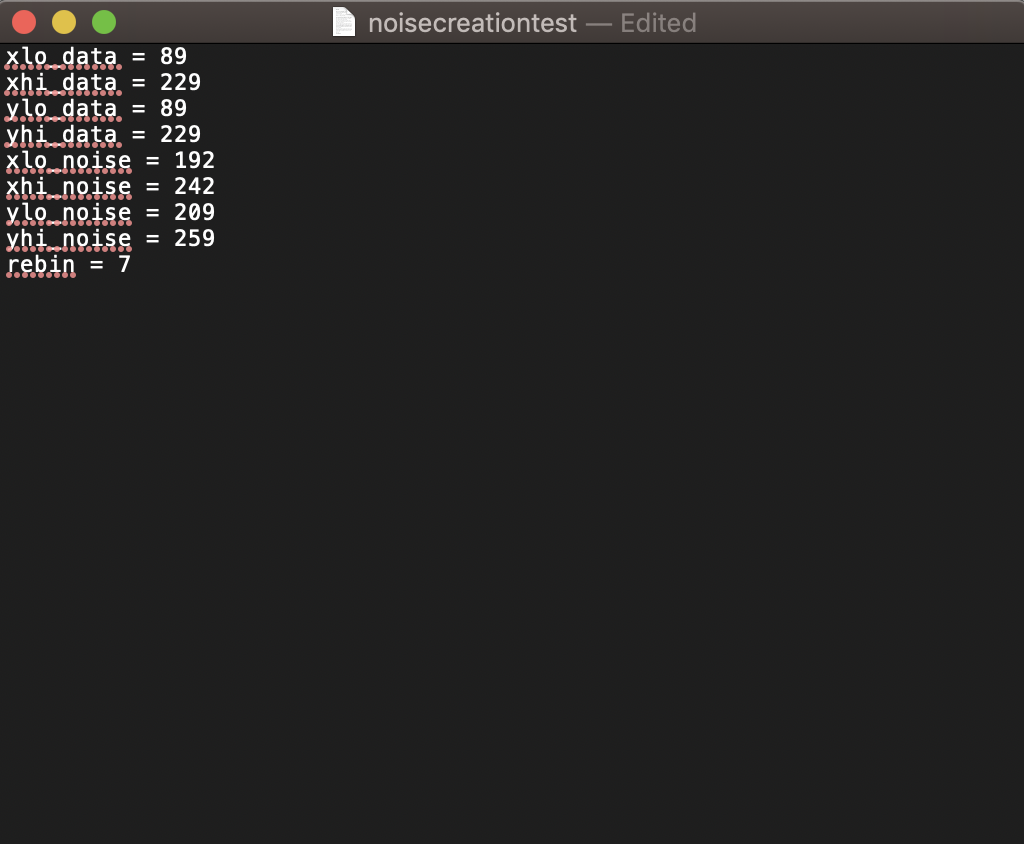

### Creating the Noise Cube with **noisecube.py**

In [9]:
nt = noisecube('NGC3258_C2C4_CO21_C2C4_bri_MS_10kms.pbcor.fits','test2','noisecreationtest.txt')
print('The median noise level in units of mJy/Beam in the cube is',1000*np.median(nt))

The median noise level in units of mJy/Beam in the cube is 0.14201971893827817


In [39]:
nt.shape

(20, 20, 162)

## Flux Maps

Flux maps are used to weight the emission line profiles, or determine the area underneath the curves of each pixel spectrum. In essence, a flux map is an image of the brightness of the galaxy. In our dynamical models, we build our models on a sub-sampled grid relative to the normal ALMA data. As in, for every ALMA pixel, we build a grid that sub-divides the single ALMA pixel into an s x s sub-grid. This it to account for possible velocity gradients within the disk that models built on the same exact scale might not be able to reproduce. Ideally, one would want a flux map that is measured with enough resolution that it matches the resolution achieved by sub-dividing each ALMA pixel into its own grid. However, this is often not possible, so what we do is often create a clean flux map by multiplying the original data cube by a mask that filters out the regions of emission and collapses the cube into a single image. This mask and clean flux map can be quite tedious to make, but when available, it provides the best way of weighting the line profiles that we currently have.

Unfortunately, I don't have all the necessary files to create a perfect NGC 3258 data cube at the moment, so we will just use a rough one created from collapsing the data cube across the channels that have emission. For NGC 4786, a clean flux map has already been created and can be used by importing it into your Jupyter notebook for usage in the dynamical modeling program.

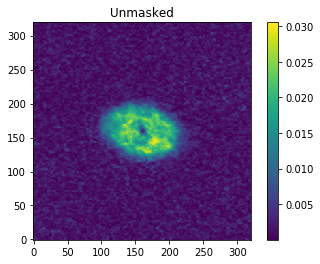

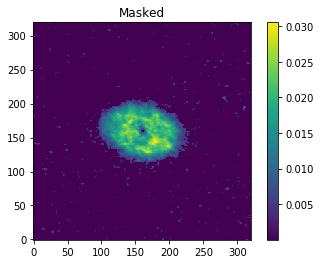

In [34]:
# Orient the data cube in the correct way 

ngc3258_data = hdul[0].data[0,:,:,:]
ngc3258_data = swap_cube_axes(ngc3258_data)

# Collapse the data cube in the spectral axis across only channels that have emission which appears to between
# channels 37 and 125 in ds9 (so 36 and 124 in Python). 

fluxmap3258 = np.sum(ngc3258_data[:,:,36:124],2)
plt.imshow(fluxmap3258,origin='lower')
plt.title('Unmasked')
cb = plt.colorbar()
plt.show()

# We can clean up the flux map a little bit by masking out all pixels that have a value less than 
# a certain factor of the median noise level. If you play around with this, you can see the image gets less and less noisy
# However, increasing it too high will remove emission as well, so it is a delicate balance. 
# I find that 30 * the median noise level seems to be produce a relatively clean flux map

maskout = np.where(fluxmap3258 < 30*np.median(nt))

# Turn these values into 1e-7 since having them as a 0 will cause errors in the dynamical modeling program.
fluxmap3258[maskout] = 1e-7

plt.imshow(fluxmap3258,origin='lower')
plt.title('Masked')
cb = plt.colorbar()
plt.show()

hdulfluxmap = fits.PrimaryHDU(fluxmap3258)
hdulfluxmap.writeto('ngc3258fluxmap.fits',overwrite=True)

# Creating a Parameter File for the Dynamical Modeling Program

To run the dynamical modeling program, an input parameter file is required. This parameter file will contain information on the specific data set that you will be trying to optimize. The description of the required parameters are listed in the dynamical.py program and an image of the parameter file I've picked for NGC 3258 is provided below. The values for the spatial and frequency axes are picked to correspond with the regions we listed for the noise cube. The parameters **N and r_init** are not that important right now, as they will be used in a later version of this notebook. For **sub**, I will pick a value of 3 as the minimum recommended value is 2, but for larger data sets, 4 starts to dramatically increase the amount of time it takes to run a dynamical model. **Rebin** is set to 7 to correspond with block-averaging the data and models to roughly a 1 pixel per 1 PSF/primary beam size scale. **gridsize** is set to 51 to create the size of the model primary-beam (or point-spread function). The gridsize needs to be an odd number and big enough that the wings of the PSF (think of it as the tails of a 1D gaussian since the PSF is actually modeled as a 2D Gaussian) are not truncated. I've used gridsizes in the range of 45-51 which always seem to be adequate. The larger the PSF, the longer the time it will take the dynamical modeling process to take.

For the following values, you can use the same values you chose for the visualization program for axial ratio, fitting ellipse center, and position angle.

**q** = 0.733

**xc_ellipse** = 159 (160 in ds9)

**yc_ellipse** = 159 (160 is ds9)

**GammaEllipse** = 75

** One important thing to note is that after your first dynamical optimization, these values are subject to change since the optimization will find a best fit $(x_c,y_c)$ as well as inclination angle and $\Gamma$ (position angle).

Lastly to pick *a*, the semimajor axis of the fitting region, open the flux map you just created in ds9 (save it as a .fits file as I did in the example for NGC 3258) and simply draw as good as an ellipse as you can that encompasses the emission without including too much of the region with noise. This is a bit subjective, but it's not hugely important if you miss some faint emission on the outskirts of the disk or include some noise region, as these disks are perfectly shaped ellipses. From the program, we can see that the long axis of this ellipse we created is about 67 pixels, so I will go ahead and set $a = 67$.

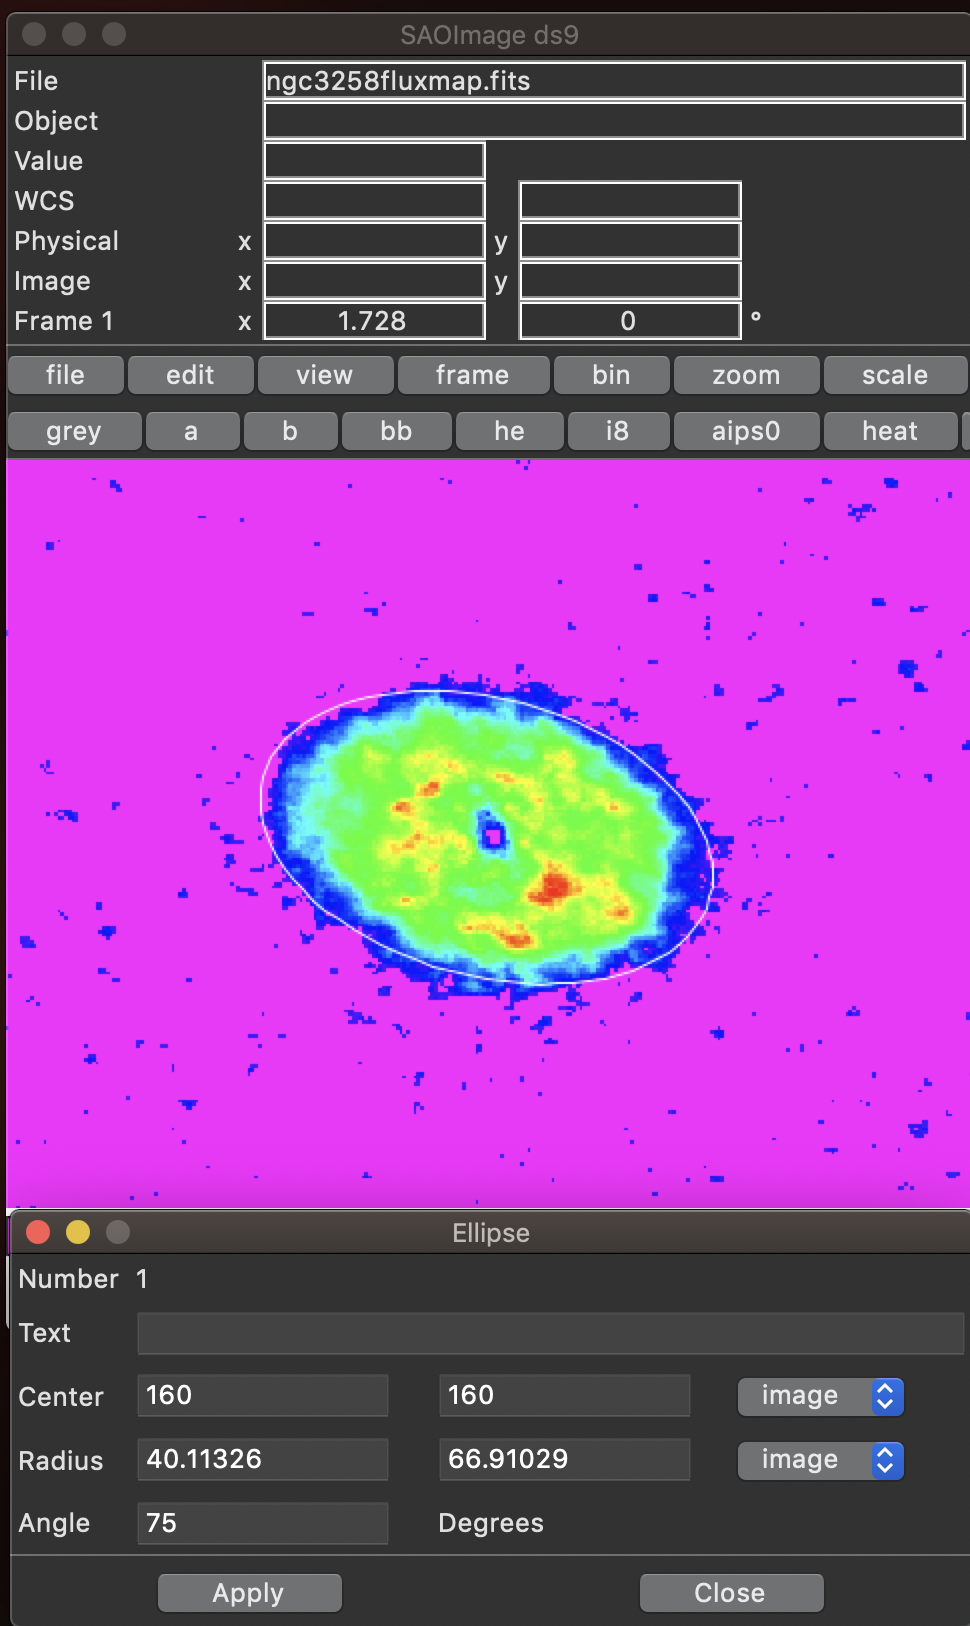

# Running a Dynamical Modeling Optimization (using a simple stellar mass power law profile)

To actually run a dynamical modeling optimization, we need to use a certain cell format that was designed for the LMFIT software. Essentially, we will specify what our initial guesses to the free parameters will be. The format for this cell looks is shown below. Essentially this is what every dynamical modeling optimization cell will look like before you execute it. As you can see, the freeparams() are the input parameters that we initially start with as a first guess, and the program will optimize these parameters in a way to minimize the $\chi^2$ value between the data and model. I will briefly explain what each parameter in this run means, and how you can decide
what to set them as. For your project, some free parameters will not be optimized at all, but are listed here as to ensure that the program runs through completion. 

When you see a parameter have **value = True**, that parameter will be optimized in the dynamical modeling fit, whereas **value = False** will not. The more free parameters with **vary = True** will usually mean that the program will take a longer time to run, which is why when we start doing these dynamical modeling optimizations, we will usually want to start simple and have as few parameters to start. A parameter with **min= ... and max = ...** indicate that we have restricted the program to only search for an optimal value in that range. Oftentimes, with certain values like BH mass, we have a pretty good idea as to what range the true value should be in, and limiting the range of parameter estimation search can increase the overall time to compeltion.

# Free Parameters for a Simple, Two-Parameter Stellar Mass Profile

For an initial dynamical modeling optimization, we will use a simple stellar mass profile for the enclosed stellar mass at each given radii, which means $M_{\star}(r) = c_1 r^{\beta}$. 

mbh: The black hole mass, and ultimately the quantity we care the most about. A good estimate of the BH mass to start if we have no idea is to use the prediction from the $M-\sigma$ relationship. The formula between BH mass and the stellar velocity dispersion, $\sigma_{\star}$ of the bulge component of the galaxy can be estimated as:

## $$ \frac{M_\mathrm{BH}}{10^9 M_{\odot}} = 0.310 \left(\frac{\sigma_{\star}}{200 \mathrm{km/s}}
\right)^{4.38} $$

The value for the bulge stellar velocity dispersion can be found from either HyperLEDA or for ALMA targets in our possession, B. Boizelle's thesis. For NGC 3258, the published result for the most complex dynamical model used is $ 2.249 \times 10^9 M_{\odot}$, so I will use that as an initial guess. I often will let there be an order of magnitude range on the minimum and maximum value on this free parameter.

MtoL: Mass to light ratio which scales the enclosed stellar mass profile. When using a Multi-Gaussian Expansion (MGE), MtoL is usually in the range of 1-4, but when using a two-power law profile, it loses its original definition and essentially becomes a constant that tries to scale the units properly between Mass and Radius along with the free parameters $c_1$ and $\beta$. There's really no good way to gauge beforehand what number to use, so I'll just start small with 10.

xc: The x center of the gas disk in pixels. Setting this to the same value that you've seleted for your ellipse is usually very close to the optimal value. I often will let the program have a range of $\pm 5$ on the center I initially pick.

yc: The y center of the gas disk in pixels. Setting this to the same value that you've seleted for your ellipse is usually very close to the optimal value. I often will let the program have a range of $\pm 5$ on the center I initially pick.

z: The redshift of the the galaxy. A good initial guess is to find out what the sytemic velocity of the galaxy is, and for nearby galaxies, an approximate formula for redshift is: $ z = v_{\mathrm{sys}}/c $. For NGC 3258 the optimized systemic velocity was found to be about 2761 km/s, which translates to

In [35]:
print('Redshift is',2761/299792.458)

Redshift is 0.00920970466842098


theta: The position angle of the gas disk, which can be taken to be the angle of the ellipse you use in ds9. 

incl: The inclination angle of the gas disk to our line of sight. We can use the relationship that $i = \arccos(q)$ for an initial guess.

In [38]:
print('Inclination angle estimate is', np.arccos(0.733)*(180/np.pi))

Inclination angle estimate is 42.861512210153066


F_0: Is a factor that multiplies the input flux map. It is meant to try and correct for any mismatch between data and model flux levels. In the case of a really good flux map, F_0 is usually around 1-1.1.

The next give 5 parameters are used for the turbulent velocity dispersion, which sets the width of each Gaussian line profile. The full turbulent velocity dispersion function used is as follows:

## $$ \sigma_0 + \sigma_1\exp\left(-(r-r_0)^2/\mu^2\right) + \sigma_2\exp\left(-r/r_0\right) $$

The second and third terms attempt to incorporate a turbulent velocity dispersion that has a Gaussian shape across the disk or a decaying exponential term. We only ever use 1 or 2 out of all 3 terms at a time. For the simplest fit, simply just set $\sigma_1 = 0$ and $\sigma_2 = 0$ and set them to **Vary=False**. Also, set $r_0$ and $\mu$ to non-zero values for now and set them to **Vary=False** as well just so the program doesn't try to divide by 0.

alpha: This is an inflow parameter that attempts to account for any possible gas inflow towards the center from the disk. Value of 1 is pure circular rotation and a value of 0 is all inflow motion. For the purposes of this project, keep the value fixed at 1.


PSF_scale: This value multiplies the major and minor axis length of the PSF/primary beam which is modeled as an elliptical Gaussian. We usually keep this to 1, but sometimes consider changing the PSF if the models aren't quite capturing all the features of the data.

Finally, we get to the parameters that create our stellar mass profile. 

c1: Scale factor for the stellar mass profile. Set it to some positive number, as like MtoL, in this context, it's hard to pre-determine what value it should be. I set no boundary on this term just so the program has the full freedom in trying to find the optimal fit.

beta: 2-3 is a good place to start, as studies have shown that power law profiles indicate they are some low power polynomial between 2-4 usually.

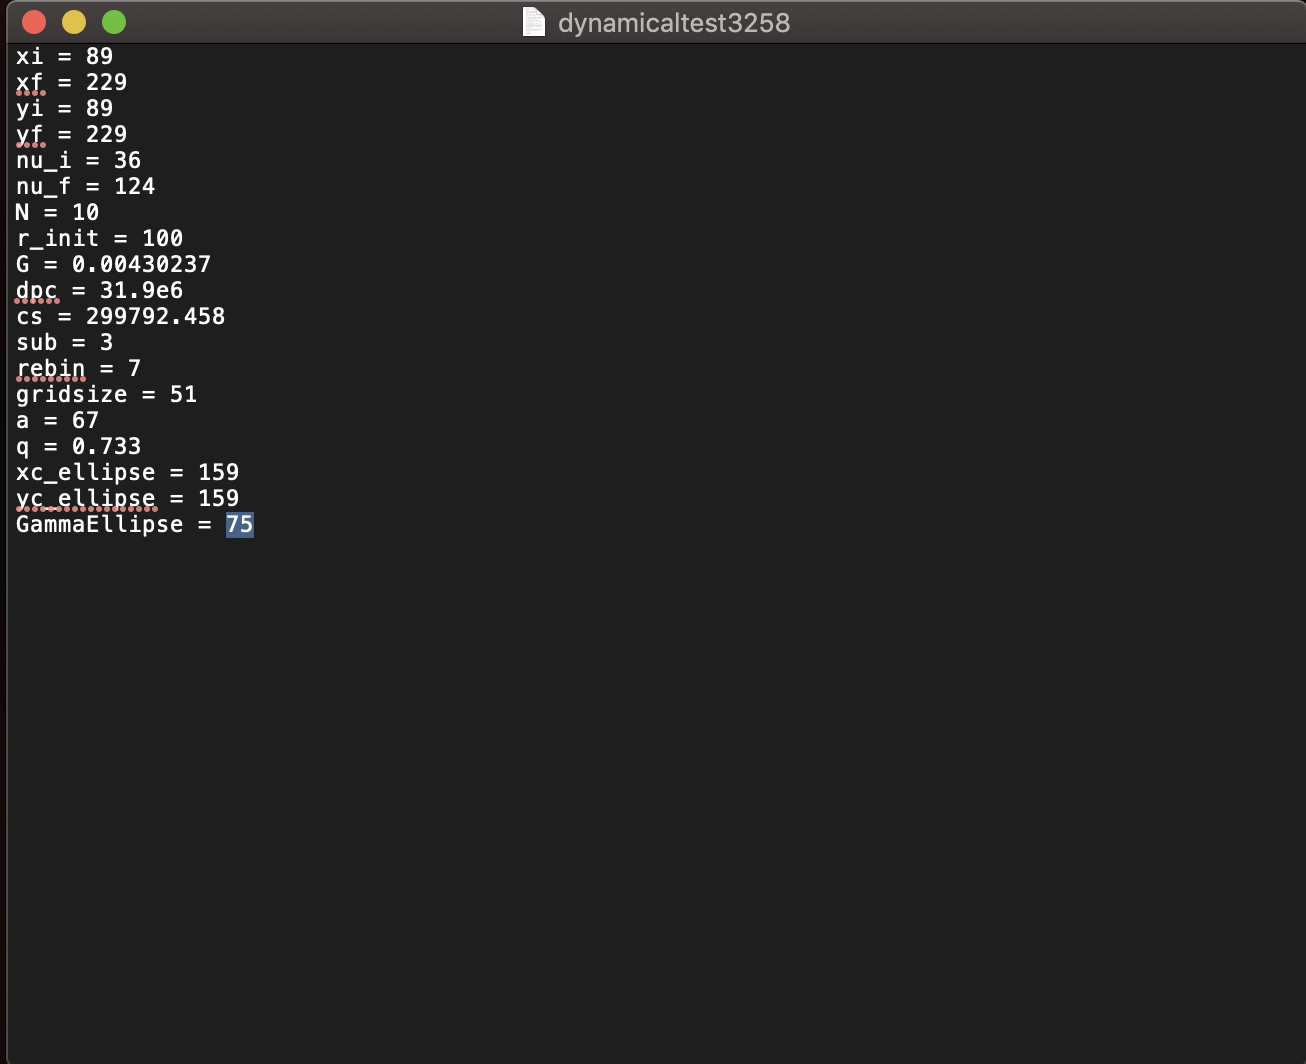

### Example Optimization Cell

The shape of the data cube is (320, 320, 162)
The major and minor axis of the primary beam in arcseconds is 0.116611324250688 0.09059044718743199
The pixel scale is 0.0150000000000012
The rest frequency of the molecular gas line in Hz is 230538000000.0
The black hole mass in solar masses is 200039958.6318119
The central x pixel is 158.76433906365457
The central y pixel is 159.03788869434925
The position angle is at 77.00413660303519
The inclination angle is at 46.57652713539174
The redshift is 0.009218664383559557
The Mass to Light ratio is 2524.9206391489624
The flux multiplier constant is 0.9285198943880185
The constant velocity dispersion term is 17.372984969502255
The amplitude of the velocity dispersion Gaussian is 0.0
The amplitude of the velocity dispersion exponential is 0.0
The radius offset of the velocity dispersion Gaussian is 1.0
The standard deviation of the velocity dispersion Gaussian is 1.0
The value of alpha is 1.0
The value of PSF scale is 1.0
No model cube is presen

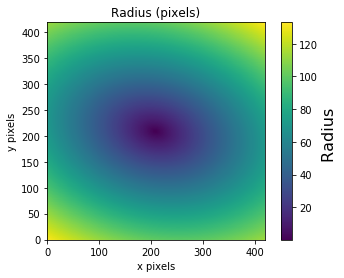

The pc to arcsec scale is 154.655419001042
The pc to pixel scale is 2.3198312850158156
The value of c1 is 250525.87553697452
The value of beta is 0.36140198047444316


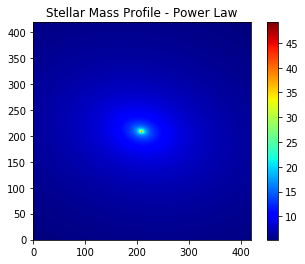

The model grid construction time in seconds is 0.3432638645172119


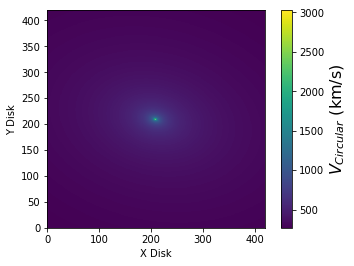

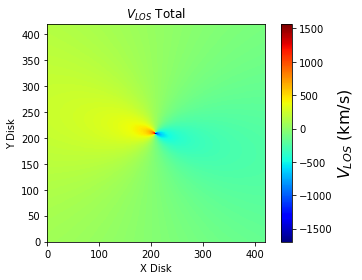

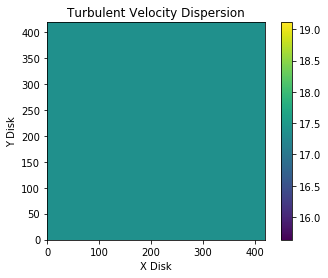

Delta frequency is -0.007812865330566
The line profile array shape is currently (420, 420, 162)
The time to construct a model line profile in seconds is 1.9560277462005615


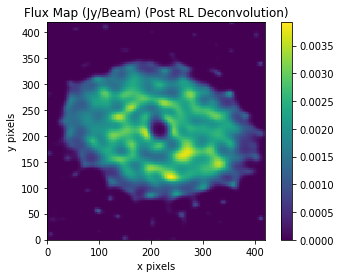

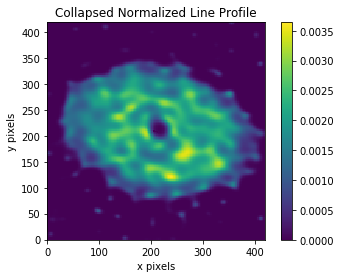

The shape of the model line profile array is (420, 420, 162)


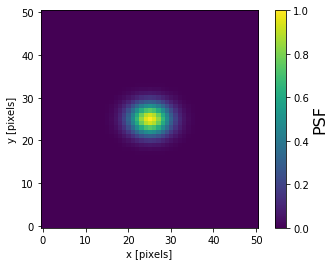

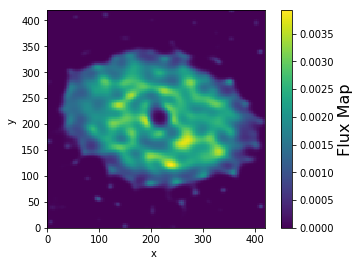

KeyboardInterrupt: 

In [62]:
# Create the free parameter place holders
freeparams = Parameters()
freeparams.add('mbh',value=2.249e9,vary=True,min=2e8,max=2e10)
freeparams.add('MtoL',value=10,min=0,vary=True)
freeparams.add('xc',value=159.0,vary=True,min=154.0,max=164.0)
freeparams.add('yc',value=159.0,vary=True,min=154.0,max=164.0)
freeparams.add('z',value=0.00920970,vary=True,min=0.0090,max=0.0094)
freeparams.add('theta',value=75,vary=True,min=70,max=80)
freeparams.add('incl',value=42.86,vary=True,min=38,max=48)
freeparams.add('F_0',value=1,vary=True,min=0,max=10)
freeparams.add('sigma_0',value=10)
freeparams.add('sigma_1',value=0.0,vary=False,min=0,max=55)
freeparams.add('sigma_2',value=0.0,vary=False,min=0,max=55)
freeparams.add('r_0',value=1,vary=False,min=0,max=100)
freeparams.add('mu',value=1,vary=False,min=-100,max=100)
freeparams.add('alpha',value=1,vary=False,min=0,max=1)
freeparams.add('PSF_scale',value=1,vary=False,min=0,max=2)
freeparams.add('c1',value=1000,vary=True,min=0.1)
freeparams.add('beta',value=3,vary=True,min=0.1,max=5)

# Run LMFIT
# Run LMFIT
start=time.time()
minimization = Minimizer(dynamical,freeparams,fcn_args=('dynamicaltest3258.txt','TestOptimization',f_range_3258,fluxmap3258,'NGC3258_C2C4_CO21_C2C4_bri_MS_10kms.pbcor.fits',nt,'power',None,None,None,None,None,None,False))
result = minimization.minimize(method='leastsq')
end=time.time()
print(end-start)

# Error report
report_fit(result)